In [1]:
# Core Libraries for Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Utilities
from sklearn.model_selection import train_test_split # To split data into training and testing sets, crucial for evaluating model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report # A comprehensive set of metrics to evaluate our classification model
import xgboost as xgb # Our chosen powerful gradient boosting algorithm for classification tasks

# Library for Model Explainability
import shap # To calculate SHAP values and visualize feature contributions, making our model's predictions interpretable

#Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All necessary libraries successfully loaded!")

All necessary libraries successfully loaded!


In [3]:
file_name = r'V:\VKfusion\pro1\file\default of credit card clients.xls'

# Read the Excel file into a pandas DataFrame.
try:
    df = pd.read_excel(file_name, header=1)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check the file name and ensure it's uploaded to Colab.")

# Display the first 5 rows for a quick data preview.
if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # Print general dataset info (columns, non-null counts, data types).
    print("\nDataset info (df.info()):")
    df.info()

Dataset loaded successfully!

First 5 rows of the dataset:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_

In [4]:
# Check and clean up column names if necessary.
print("\nOriginal Column Names:")
print(df.columns)

# Drop the 'ID' column. It's a unique identifier, not a feature for the model,
# and keeping it could lead to overfitting.
if 'ID' in df.columns:
    df = df.drop('ID', axis=1) # axis=1 specifies that we're dropping a column
    print("\n'ID' column removed.")
else:
    print("\n'ID' column not found.")

# Define and standardize the target variable name.
# In the UCI dataset, the target is typically 'default payment next month'.
# Renaming it to 'DEFAULT' makes it shorter and easier to work with.
target_column = 'default payment next month'
if target_column in df.columns:
    df = df.rename(columns={target_column: 'DEFAULT'})
    print(f"'{target_column}' column renamed to 'DEFAULT'.")
else:
    print(f"'{target_column}' column not found. Please check your target column name.")

# Display the updated column names.
print("\nUpdated Column Names:")
print(df.columns)

# Show the dataset dimensions (rows, columns).
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

# Check for missing values in each column.
print("\nMissing values per column:")
print(df.isnull().sum())

# Summarize if any missing values are present.
if df.isnull().sum().sum() == 0:
    print("\nNo missing values found in the dataset. Great!")
else:
    print("\nMissing values are present in the dataset. We would typically handle them here (e.g., imputation or dropping).")
    # For the UCI dataset, significant missing values are usually not an issue, but it's common in real-world data.

# Re-check data types for all columns.
print("\nCurrent Column Data Types:")
print(df.dtypes)


Original Column Names:
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

'ID' column removed.
'default payment next month' column renamed to 'DEFAULT'.

Updated Column Names:
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

Dataset shape: 30000 rows, 24 columns

Missing values per column:
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY

In [5]:
# Identify categorical columns.
# Based on `df.info()` and domain knowledge, 'SEX', 'EDUCATION', and 'MARRIAGE' are treated as categorical.
# While 'PAY_0' through 'PAY_6' appear numerical, they represent ordinal categories (payment status).
# XGBoost can generally handle these numerical ordinal categories directly, so we'll only One-Hot Encode
# 'SEX', 'EDUCATION', and 'MARRIAGE' for now.

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

# Apply One-Hot Encoding to the identified categorical columns.
# `drop_first=True` prevents multicollinearity by dropping one of the resulting binary columns for each feature.
# For example, for 'SEX', only 'SEX_2' (Female) will be created, where 1 means Female and 0 means Male.
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


print("\nFirst 5 rows of the dataset after One-Hot Encoding:")
print(df_encoded.head())

print("\nColumns of the dataset after One-Hot Encoding:")
print(df_encoded.columns)

print(f"\nShape of the dataset after One-Hot Encoding: {df_encoded.shape[0]} rows, {df_encoded.shape[1]} columns")


First 5 rows of the dataset after One-Hot Encoding:
   LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0      20000   24      2      2     -1     -1     -2     -2       3913   
1     120000   26     -1      2      0      0      0      2       2682   
2      90000   34      0      0      0      0      0      0      29239   
3      50000   37      0      0      0      0      0      0      46990   
4      50000   57     -1      0     -1      0      0      0       8617   

   BILL_AMT2  ...  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
0       3102  ...   True        False         True        False        False   
1       1725  ...   True        False         True        False        False   
2      14027  ...   True        False         True        False        False   
3      48233  ...   True        False         True        False        False   
4       5670  ...  False        False         True        False        False   

   EDUCATION_5  EDUCA

In [6]:
# Separate features (X) from the target variable (y).
# X includes all columns except 'DEFAULT'.
X = df_encoded.drop('DEFAULT', axis=1)
y = df_encoded['DEFAULT'] # The target variable

print("\nFirst 5 rows of the features (X) dataset:")
print(X.head())

print("\nFirst 5 values of the target variable (y):")
print(y.head())

print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


First 5 rows of the features (X) dataset:
   LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0      20000   24      2      2     -1     -1     -2     -2       3913   
1     120000   26     -1      2      0      0      0      2       2682   
2      90000   34      0      0      0      0      0      0      29239   
3      50000   37      0      0      0      0      0      0      46990   
4      50000   57     -1      0     -1      0      0      0       8617   

   BILL_AMT2  ...  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
0       3102  ...   True        False         True        False        False   
1       1725  ...   True        False         True        False        False   
2      14027  ...   True        False         True        False        False   
3      48233  ...   True        False         True        False        False   
4       5670  ...  False        False         True        False        False   

   EDUCATION_5  EDUCATION_6  MA

In [7]:
# Split the dataset into training and testing sets.
# test_size: The proportion of the dataset to include in the test split (e.g., 20%).
# random_state: A fixed seed for reproducibility, ensuring the same split every time the code runs.
# stratify=y: Crucial for imbalanced datasets, this ensures the proportion of target classes (0s and 1s)
#             is maintained in both training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set X shape: {X_train.shape}")
print(f"Training set y shape: {y_train.shape}")
print(f"Test set X shape: {X_test.shape}")
print(f"Test set y shape: {y_test.shape}")

# Check the distribution of the 'DEFAULT' target variable in both sets.
print("\n'DEFAULT' distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\n'DEFAULT' distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set X shape: (24000, 30)
Training set y shape: (24000,)
Test set X shape: (6000, 30)
Test set y shape: (6000,)

'DEFAULT' distribution in training set:
DEFAULT
0    0.778792
1    0.221208
Name: proportion, dtype: float64

'DEFAULT' distribution in test set:
DEFAULT
0    0.778833
1    0.221167
Name: proportion, dtype: float64


In [8]:
# Define the XGBoost Classifier model.
# Hyperparameters are crucial for tuning model performance and preventing overfitting:
# - objective: 'binary:logistic' for binary classification, outputting probabilities.
# - eval_metric: 'logloss' is a good choice for evaluating performance during training in binary classification.
# - use_label_encoder=False: Recommended for compatibility with newer versions of XGBoost.
# - n_estimators: Number of boosting rounds (trees). More trees can mean better performance but longer training.
# - learning_rate: Shrinks the contribution of each tree. Lower values require more trees but can build a more robust model.
# - max_depth: Maximum depth of each tree, helps control model complexity.
# - subsample: Fraction of samples used for fitting the trees.
# - colsample_bytree: Fraction of features used for each tree (column sampling).
# - gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree.
# - reg_alpha (L1) and reg_lambda (L2): Regularization terms to prevent overfitting.

print("\nStarting XGBoost model training...")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # Outputting probability for binary classification
    eval_metric='logloss',       # Evaluation metric during training
    use_label_encoder=False,     # Compatibility setting for newer versions
    n_estimators=200,            # Number of boosting rounds
    learning_rate=0.1,           # Step size shrinkage to prevent overfitting
    max_depth=5,                 # Maximum depth of a tree
    subsample=0.8,               # Subsample ratio of the training instance
    colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
    gamma=0.1,                   # Minimum loss reduction required to make a further partition
    random_state=42,             # For reproducibility
    n_jobs=-1                    # Use all available CPU cores for faster training
)

# Train the model using the training data
xgb_model.fit(X_train, y_train)

print("\nXGBoost model training completed successfully!")


Starting XGBoost model training...

XGBoost model training completed successfully!


Model Evaluation Results:
---------------------------------
Accuracy: 0.8162
Precision: 0.6526
Recall: 0.3610
F1-Score: 0.4648
ROC AUC Score: 0.7728

Confusion Matrix:
[[4418  255]
 [ 848  479]]


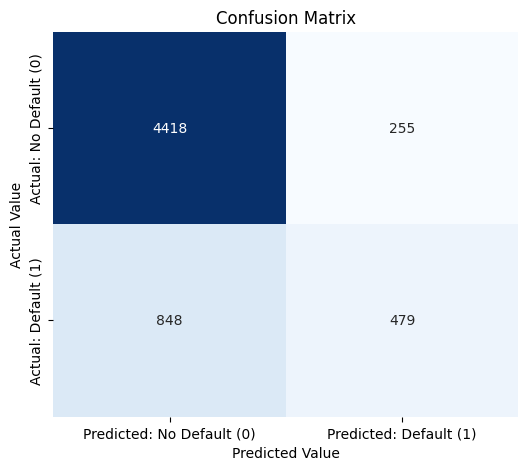


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [9]:
# Make predictions on the test set.
y_pred = xgb_model.predict(X_test)         # Class predictions (0 or 1)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1 - default)

print("Model Evaluation Results:")
print("---------------------------------")

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# 3. Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# 4. F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize the Confusion Matrix for better understanding.
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: No Default (0)', 'Predicted: Default (1)'],
            yticklabels=['Actual: No Default (0)', 'Actual: Default (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.show()

# 7. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

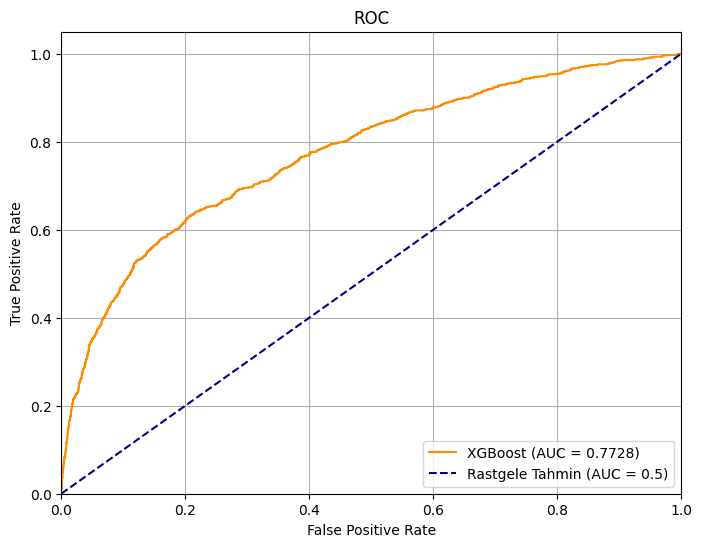

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Rastgele Tahmin (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Starting SHAP analysis...
SHAP values successfully calculated.

Global Feature Importance (SHAP Summary Plot - Bar):


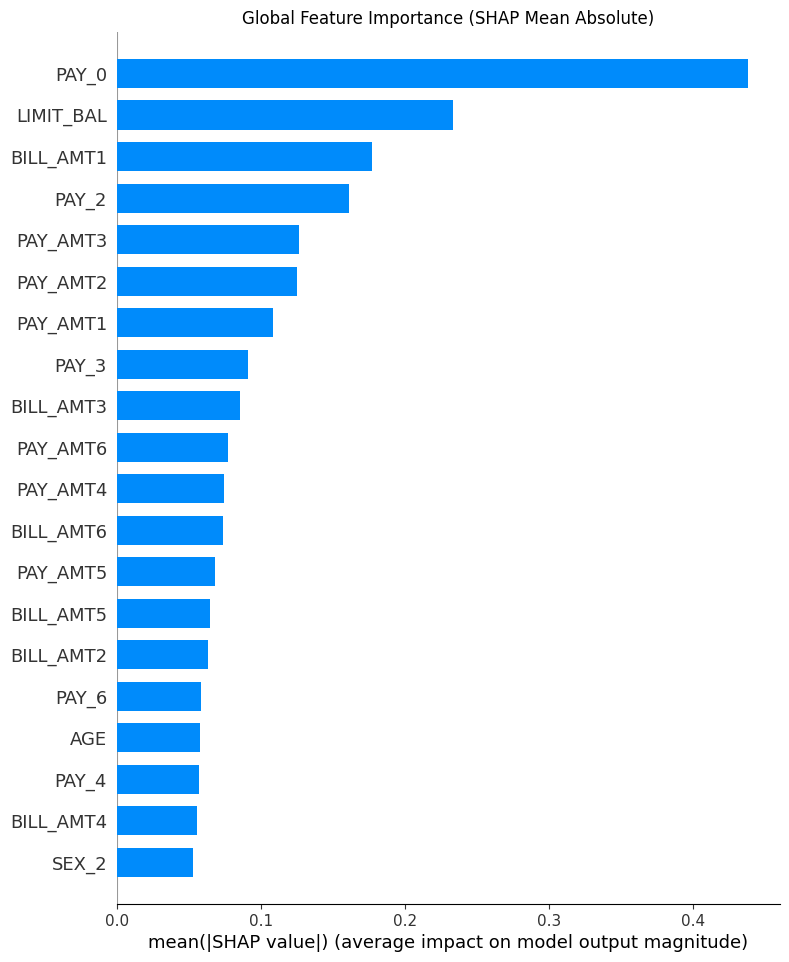


Global Feature Contributions to Predictions (SHAP Summary Plot - Beeswarm):


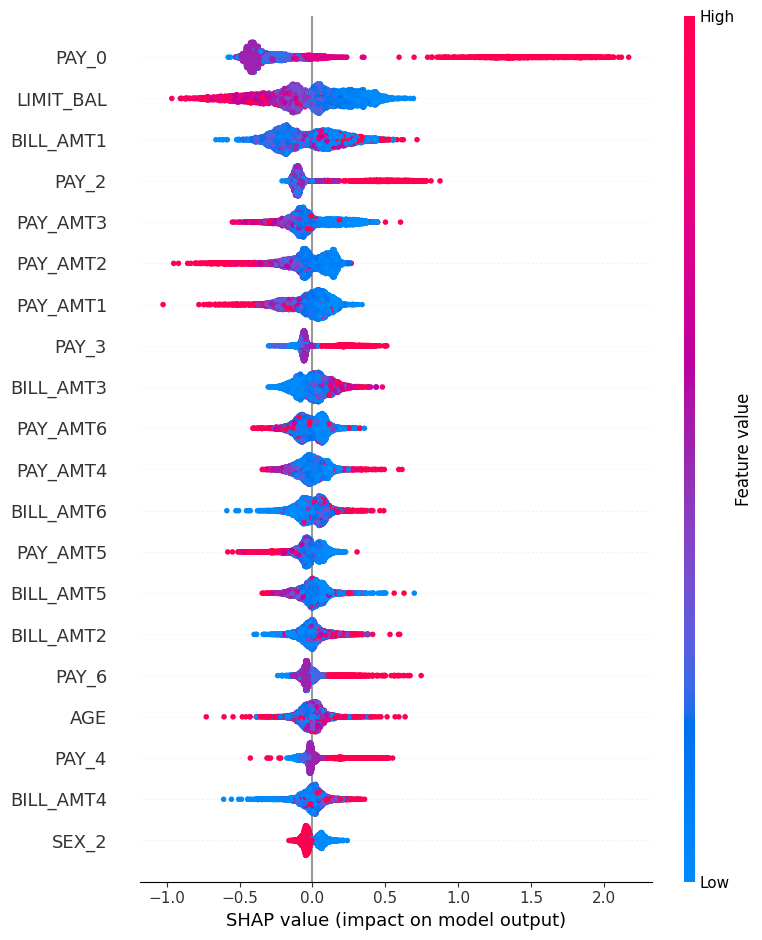

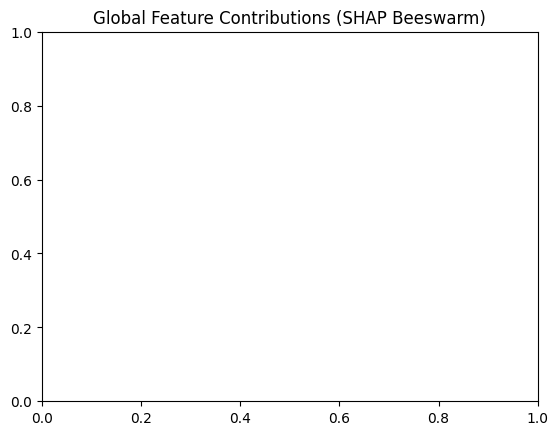


SHAP Force Plot for selected instance (Index: 0):

SHAP Force Plot for the first 5 instances (Multiple Instances):


In [11]:
# To ensure SHAP visualizations render correctly in Jupyter/Colab, we initialize the JavaScript library.
shap.initjs()

print("Starting SHAP analysis...")

# 1. Create a SHAP Explainer.
# TreeExplainer is optimized for tree-based models like XGBoost.
explainer = shap.TreeExplainer(xgb_model)

# 2. Compute SHAP values for the test set.
# This step calculates the contribution of each feature to the model's prediction for every instance in X_test.
# This process might take some time, especially with larger datasets.
shap_values = explainer.shap_values(X_test)

print("SHAP values successfully calculated.")

# 3. Global Feature Importance (Overall Impact of Features)

# SHAP Summary Plot (Bar chart): Shows the mean absolute SHAP value for each feature,
# indicating its average impact magnitude on model output.
print("\nGlobal Feature Importance (SHAP Summary Plot - Bar):")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP Mean Absolute)')
plt.show()

# SHAP Summary Plot (Beeswarm Plot): Displays the distribution of SHAP values for each feature.
# Each dot represents an instance, its position on the x-axis indicates the feature's impact on the prediction,
# and its color often shows the feature's actual value (e.g., low to high).
# Dots to the right indicate features increasing the prediction (e.g., higher default risk),
# while dots to the left indicate decreasing the prediction.
print("\nGlobal Feature Contributions to Predictions (SHAP Summary Plot - Beeswarm):")
shap.summary_plot(shap_values, X_test) # Default plot_type is usually 'dot' or 'beeswarm'
plt.title('Global Feature Contributions (SHAP Beeswarm)')
plt.show()


# 4. Local Interpretability (Explaining Individual Predictions)

# Select a random test instance to explain its specific prediction.
sample_index = 0 # You can choose any other index (e.g., 5, 10, etc.)
print(f"\nSHAP Force Plot for selected instance (Index: {sample_index}):")

# Generate a Force Plot for the individual prediction.
# Red portions: Features pushing the prediction higher (increasing default risk).
# Blue portions: Features pushing the prediction lower (decreasing default risk).
# The length of the bars indicates the magnitude of the impact.
# Base Value: The average model output (e.g., the average probability of default).
# Output Value: The actual prediction (probability of default) for the selected instance.
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index])

# Note: In environments like Colab or Jupyter, the force_plot typically renders directly.

# Optional: Visualize SHAP Force Plots for multiple instances simultaneously.
print("\nSHAP Force Plot for the first 5 instances (Multiple Instances):")
shap.force_plot(explainer.expected_value, shap_values[:5], X_test.iloc[:5])